# Prediction of Officer's Rank 

**Kancheng Yin, Xuewen(Daphne) Yang**

## Summary of Findings


### Introduction
- This dataset in this project contains filled civilian complaints against the New York City police officers. For police officers, their ranking have effects on their authority and responsibility and implies the police culture they usually engage during work. Hence, it is useful predict the ranking of a police officer as it may reflect some about that officer. 

- We plan to predict, as of July 2020, the rank of an officer that got filed with a complaint. The relavent data stored in the `'rank_now'` column. Since there are several ranking and the ranking is a categorical variable, we decided to use multiclass classification for our prediction.

- We choose balanced accuracy for our metric. It's most important for our model to correctly predict the ranking of an officer. False positives and false negatives does not have much of a concern for us.

- Since we are planning to predict the officer's latest rank, we are going to only use data that can be obtained during the time of the incident to form our features.


### Baseline Model

- We are using 2 categorical features (`'mos_gender'` and `'mos_ethnicity'`) for prediction:
    - Both features are encoded using `OneHotEncoder`
- We chose `DecisionTreeClassifier` as our classifier
    - Our performance metric is around 0.13 for both the training and testing dataset.
- This current model is not ideal since its performance metric is poor. However, it's performance between the training and testing set is similar, meaning that the classifier did not overfit the data.


### Final Model

- We added 4 new features for prediction:
    - Categorical columns: `'complainant_gender'`, `'complainant_ethnicity'`, and `'rank_incident'`. 
        * We use `FunctionTransformer` to derive new features `'same_gender'` and `'same_ethnicity'` that show whether or not the police and the complainant have the same gender or same ethnicity. 
        * Then we one-hot encode these two new features and the `'rank_incident'` feature.
    - Quantitative column: `'mos_age_incident'`. 
        * We use `'StandardScaler'` to standardize the `'mos_age_incident'` column.
- We chose `DecisionTreeClassifier` as our classifier. By using `GridSearchCV`, the best hyperparameters obtained are `'gini'` and 14 for criterion and max_depth, respectively.
- This model is still not a good fit since it has low `balanced_accuracy_score`. However, our model improved from 0.13 to 0.34 on both the training and testing dataset, showing that the added features help improve the model.

### Fairness Analysis
> **Null Hypothesis**: Our model is fair. Its balanced accuracy for female and male officers are roughly the same, and any differences are due to random chance.<br>
**Alternative Hypothesis**: Our model is unfair. Its balanced accuracy for male officers is higher than its balanced accuracy for female officers.<br>
**Test Statistic**: `balanced_accuray_male` - `balanced_accuray_female`

Since our p-value from our permutation test is smaller than 0.05, we reject the null hypothesis. It seems like the difference we've observed is not due to random chance and our model maybe unfair performance between male and female officers.

## Code

In [1]:
# Import packages needed for analysis
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [2]:
# Load the data of NYPD Civilian Complaints
data = os.path.join('data', 'allegations_202007271729.csv')
police_data = pd.read_csv(data)
print(police_data.shape)
police_data.head()

(33358, 27)


,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions)
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,...,25,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges)
4,10009,Noemi,Sierra,078 PCT,24058,40253,8,2018,2,2019,...,39,NaN,NaN,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Substantiated (Command Discipline A)


Checking for missingness and data types in `police_data`

In [3]:
police_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33358 entries, 0 to 33357
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   unique_mos_id             33358 non-null  int64  
 1   first_name                33358 non-null  object 
 2   last_name                 33358 non-null  object 
 3   command_now               33358 non-null  object 
 4   shield_no                 33358 non-null  int64  
 5   complaint_id              33358 non-null  int64  
 6   month_received            33358 non-null  int64  
 7   year_received             33358 non-null  int64  
 8   month_closed              33358 non-null  int64  
 9   year_closed               33358 non-null  int64  
 10  command_at_incident       31814 non-null  object 
 11  rank_abbrev_incident      33358 non-null  object 
 12  rank_abbrev_now           33358 non-null  object 
 13  rank_now                  33358 non-null  object 
 14  rank_i

Column `'rank_now'` does not have any missing values. Therefore we shall leave the dataframe as it is for now and will do permutation later if we decided to create features from columns.

Now we anaylze the type of data in `'rank_now'`

In [4]:
police_data['rank_now'].value_counts()

Police Officer            10298
Detective                  9917
Sergeant                   7751
Lieutenant                 3696
Captain                     735
Deputy Inspector            435
Chiefs and other ranks      312
Inspector                   214
Name: rank_now, dtype: int64

`'rank_now'` has categorical values with 8 different types. Therefore we will perform a multiclass classification for our prediction.

### Baseline Model

In [5]:
# Import packages needed for model predictions
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder, StandardScaler,
                                   FunctionTransformer)
from sklearn.compose import ColumnTransformer
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore') 

We believe that the gender of the ethnicity may have an influence on an officer's ranking and so we decided to use `'mos_gender'` and `'mos_ethnicity'` to predict the lastest ranking of the officer for our baseline model.

First, we split our dataset into a training group and a testing group:

In [6]:
# Split dataframe into training and testing set
X = police_data[['mos_gender', 'mos_ethnicity']]
y = police_data['rank_now']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [7]:
police_data[['mos_gender', 'mos_ethnicity']].head()

,mos_gender,mos_ethnicity
0,M,Hispanic
1,M,White
2,M,White
3,M,White
4,F,Hispanic


Since both `'mos_gender'` and `'mos_ethnicity'` are categorical variables, we shall use `OneHotEncoder` to transform them. We will use `DecisionTreeClassifier` as our model for multiclass prediction.

In [8]:
# Create a Pipeline to perform feature transformation and model training
pl = Pipeline([
    ('preproc', ColumnTransformer(
        transformers = [
            ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'),
             ['mos_ethnicity', 'mos_gender'])
        ])
    ),
    ('clf', DecisionTreeClassifier())
])

# Fit our pipeline with the training dataset
pl.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['mos_ethnicity',
                                                   'mos_gender'])])),
                ('clf', DecisionTreeClassifier())])

In [9]:
# Obtain our performance metric on training data
metrics.balanced_accuracy_score(y_train, pl.predict(X_train))

0.13486502771676734

In [10]:
# Obtain our performance metric on testing data
metrics.balanced_accuracy_score(y_test, pl.predict(X_test))

0.13668966260424797

### Final Model

In [11]:
# Split dataframe into training and testing set
X2 = police_data[['mos_gender', 'complainant_gender', 'mos_ethnicity', 
                  'complainant_ethnicity', 'mos_age_incident', 'rank_incident']]
y2 = police_data['rank_now']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2)

In [12]:
def modify(df):
    res = pd.DataFrame()
    res['same_gender'] = df['mos_gender'] == df['complainant_gender']
    res['same_ethnicity'] = df['mos_ethnicity'] == df['complainant_ethnicity']
    return res

# Pipeline for transforming the gender and ethnicity columns of police and
# complainants and performing one-hot encoding
p = Pipeline([
    ('modify', FunctionTransformer(modify)),
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first')),
])


# Create a Pipeline to perform feature transformation and model training
pl2 = Pipeline([
    ('preproc', ColumnTransformer(
        transformers = [
            ('modify', p, ['mos_gender', 'complainant_gender',
                           'mos_ethnicity', 'complainant_ethnicity']),
            ('ohe', OneHotEncoder(handle_unknown = 'ignore', drop='first'),
             ['rank_incident']),
            ('std', StandardScaler(), ['mos_age_incident'])
        ])
    ),
    ('clf', DecisionTreeClassifier())
])

In [13]:
hyperparameters = {
    'clf__max_depth': np.arange(2, 50),
    'clf__criterion': ['gini', 'entropy']
}

# Get the best hyperparameters using GridSearchCV
searcher = GridSearchCV(pl2, hyperparameters, cv=5, scoring = 'balanced_accuracy')

# Fit our searcher with the training dataset
searcher.fit(X_train2, y_train2)
searcher.best_params_

{'clf__criterion': 'entropy', 'clf__max_depth': 9}

In [14]:
# Obtain our performance metric on training data
metrics.balanced_accuracy_score(y_train2, searcher.predict(X_train2))

0.350411795967278

In [15]:
# Obtain our performance metric on testing data
metrics.balanced_accuracy_score(y_test2, searcher.predict(X_test2))

0.3380721468713414

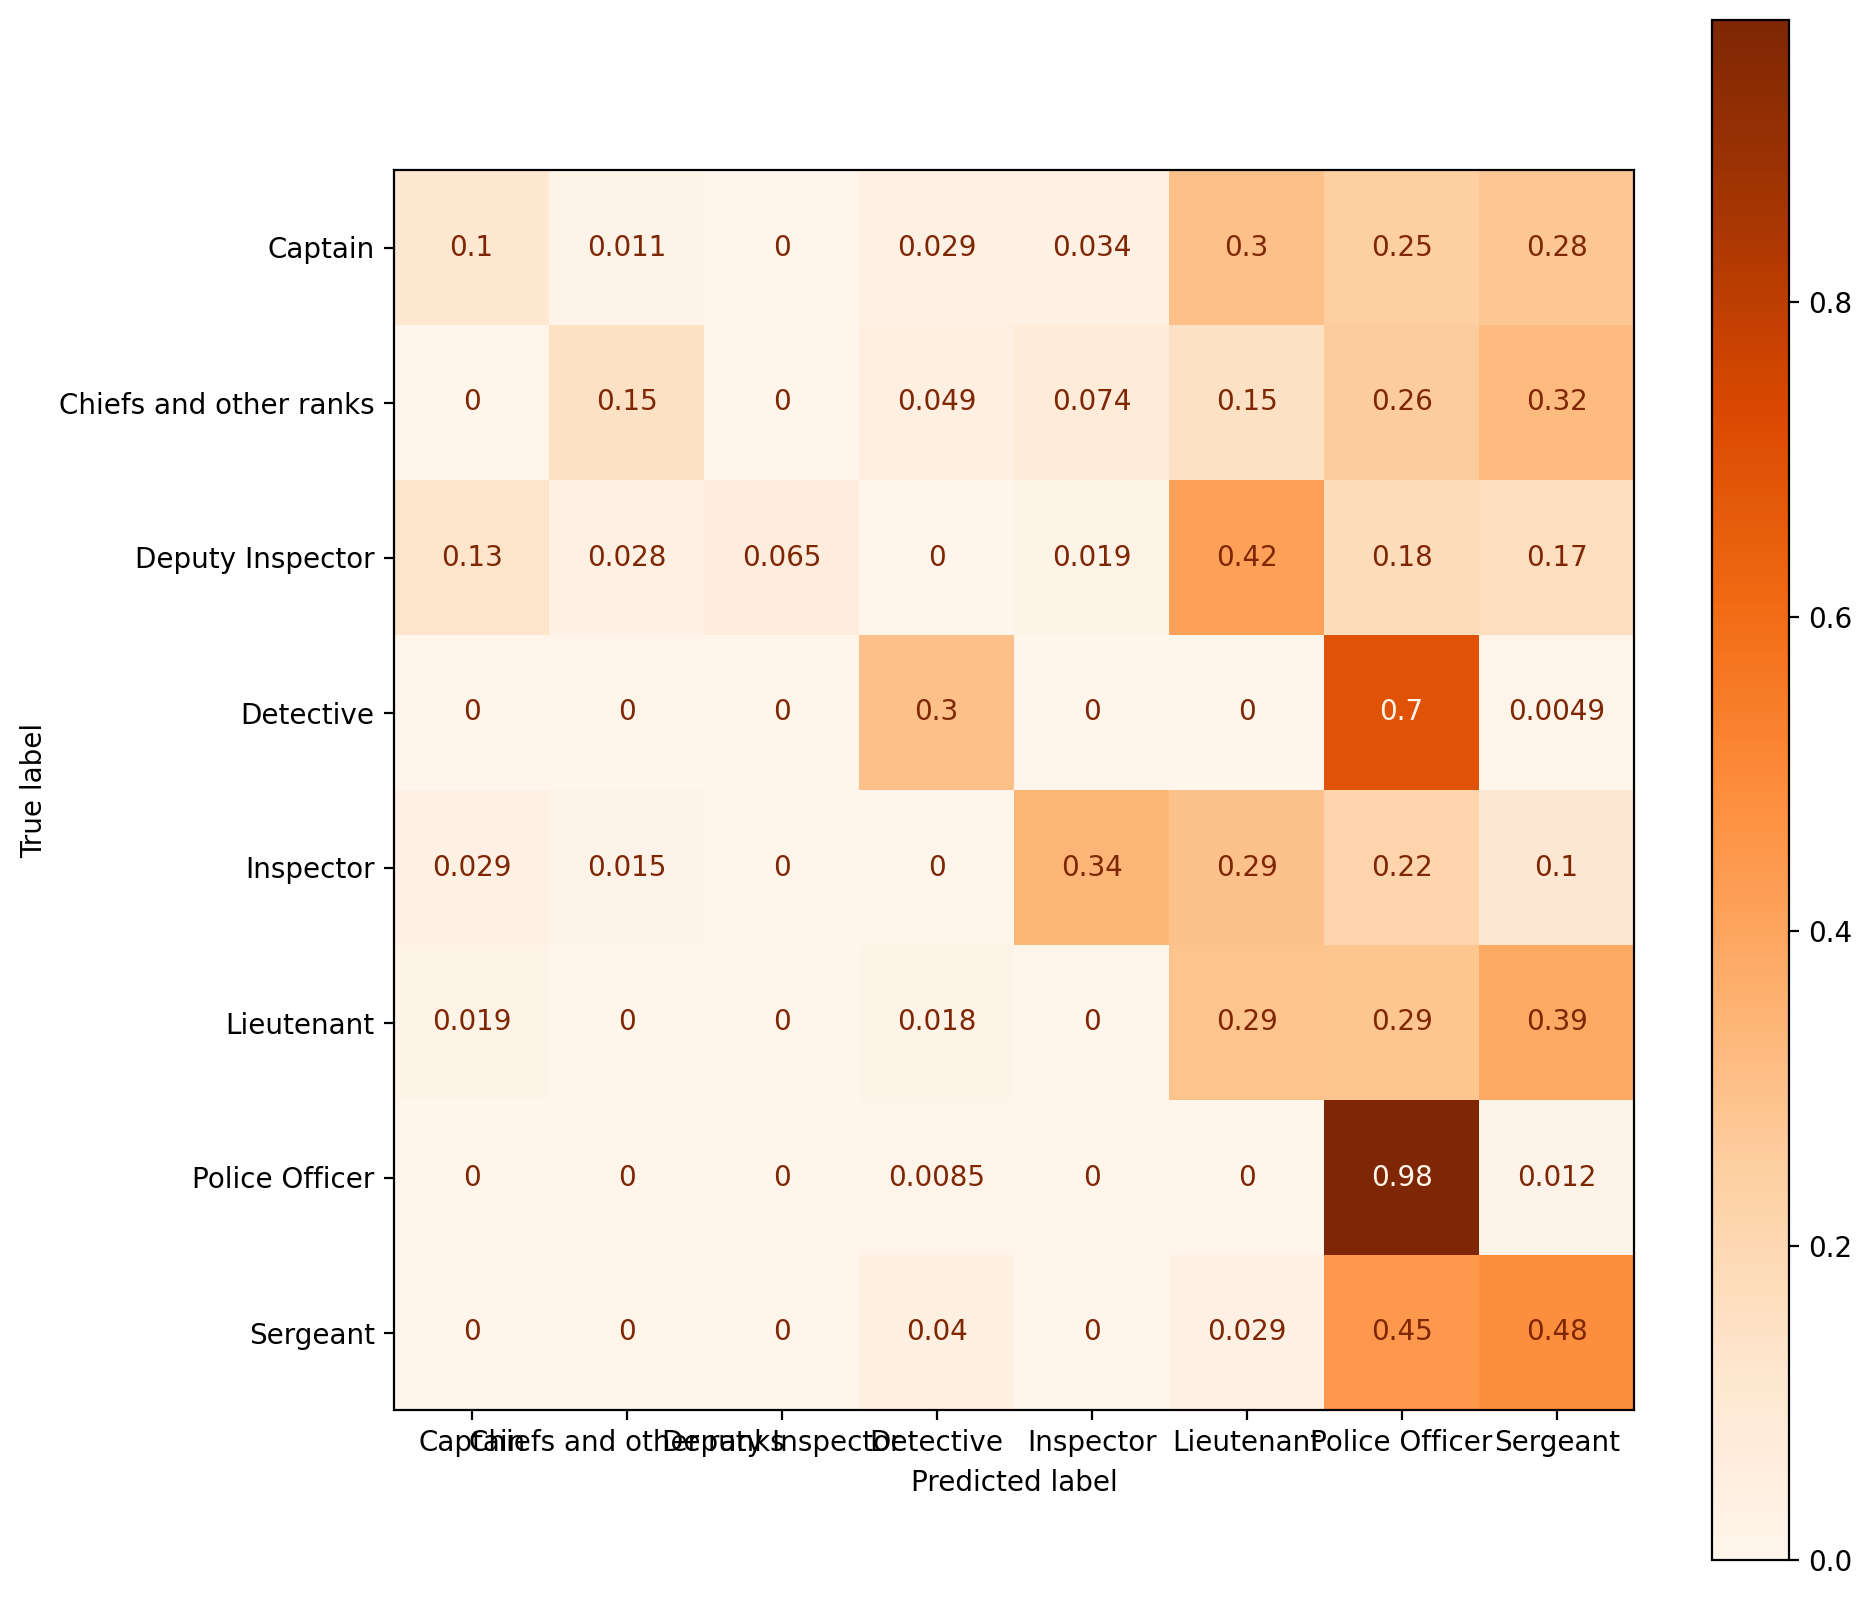

In [20]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
metrics.plot_confusion_matrix(searcher, X_test2, y_test2,normalize='true', ax=ax,cmap='Oranges')
plt.show()

### Fairness Analysis

In this section, we want to see if our model gives similar performance between officers of different genders.

In [17]:
police_data['mos_gender'].unique()

array(['M', 'F'], dtype=object)

Since there are only two genders in the `'mos_gender'`, we can carry on our analysis and form our hypotheses:

>**Null Hypothesis**: Our model is fair. Its balanced accuracy for female and male officers are roughly the same, and any differences are due to random chance.<br>
**Alternative Hypothesis**: Our model is unfair. Its balanced accuracy for male officers is higher than its balanced accuracy for female officers.<br>
**Test Statistic**: `balanced_accuray_male` - `balanced_accuray_female`

First we assign a new column `'mos_is_male'` to the dataframe. The value will be `True` if the gender of the officer is male, otherwise `False`.

In [18]:
# Add new column to the dataframe
police_data['mos_is_male'] = police_data['mos_gender'] == 'M'

Now we create a function that helps us calculate the test statistic:

In [19]:
# define function that calculates the difference between the model metrics of
# male and female officers
def f1_diff(m_df,f_df):
    m_accuracy = metrics.balanced_accuracy_score(m_df['rank_now'],
                                                 searcher.predict(m_df))
    f_accuracy = metrics.balanced_accuracy_score(f_df['rank_now'],
                                                 searcher.predict(f_df))
    
    return m_accuracy - f_accuracy

In [20]:
# Obtain the metric difference between male and female officers
male = police_data[police_data['mos_is_male']]
female = police_data[~police_data['mos_is_male']]
obs_diff = f1_diff(male,female)
print('difference:', obs_diff)

difference: 0.056551016855769076


Now we run a permutation test with 500 trials and store the test statistic for all trials in `perm_diffs`

In [21]:
# Run a permutation test
perm_diffs = []
for _ in range(500):
    police_data['gender_perm'] = np.random.permutation(
        police_data['mos_is_male'].values
    )
    male = police_data[police_data['gender_perm']]
    female = police_data[~police_data['gender_perm']]

    perm_diffs.append(f1_diff(male,female))

In [22]:
# Obtain p-value
(perm_diffs > obs_diff).mean()

0.006

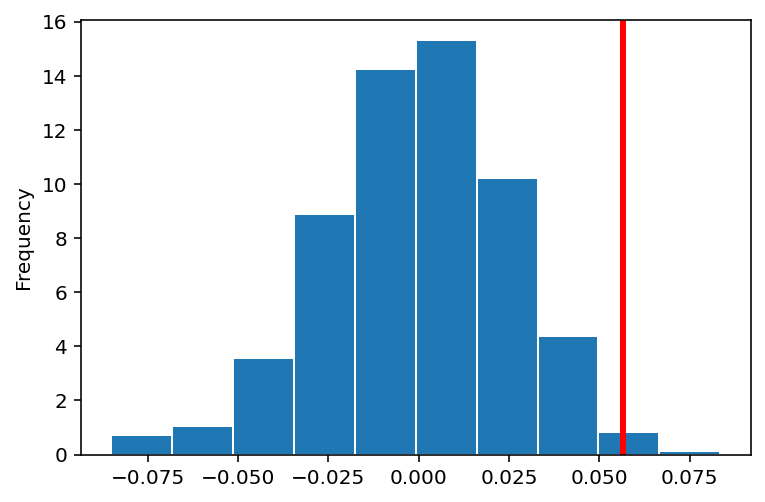

In [23]:
# Visualize the distribution of the permutation set reuslts
pd.Series(perm_diffs).plot(kind='hist', density=True, ec='w')
plt.axvline(x=obs_diff, color='red', linewidth=3);

- Our p-value is around 0.006, which is smaller than our threshold of 0.05. Therefore, we reject the null hypothesis in favor of the alternative hypothesis. It seems like our model maybe biased towards giving higher balanced accuracy scores for male officers.